# Jitter Fisher Analysis

Telescope jitter will negatively effect an inference algorithm's ability to constrain all its other parameters. In the case of the TOLIMAN telescope, we are primarily concerned with the ability to constrain the binary separation. In this notebook we will perform a Fisher analysis to determine the effect of jitter on the ability to constrain these parameters.

First let's configure the notebook.

In [1]:
import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
# os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

import dLux as dl
import matplotlib.pyplot as plt
import dLuxToliman as dlT
import zodiax as zdx
from jax import numpy as np
import jax
from tqdm.notebook import tqdm

from detector_layers import ApplyJitter

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
# plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

## Building Model
Here we build our dLux forwards model with parametric jitter.

In [2]:
pscale = .375  # arcsec/pixel
det_npix = 128
oversample = 8
kernel_oversample = 12
wf_npixels = 512
kernel_size = 17  # odd integer
jitter_params = {"r": 1e-5, "shear": 0, "phi": 0}
radial_orders = [2, 3]

In [3]:
src = dlT.AlphaCen()
det = dl.LayeredDetector([
    (ApplyJitter(**jitter_params, kernel_size=kernel_size, kernel_oversample=kernel_oversample), 'Jitter'),
    (dl.IntegerDownsample(oversample), 'Downsample'),
])

osys = dlT.TolimanOptics(wf_npixels=512, radial_orders=radial_orders, psf_pixel_scale=pscale, psf_oversample=oversample, psf_npixels=det_npix*oversample)
osys = osys.divide('aperture.basis', 1e9) # Set basis units to nanometers

telescope = dl.Instrument(sources=src, optics=osys, detector=det)


## Visualising the Jitter Parameters
Our jitter parameters are $r$, shear and $\phi$. $r$ is the magnitude of the jitter in pixels, $\phi$ is the angle of the jitter in degrees and shear is a measure of how linear the jitter is.

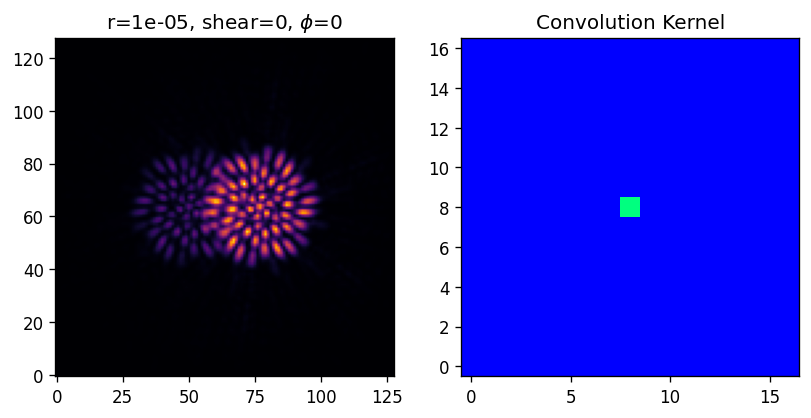

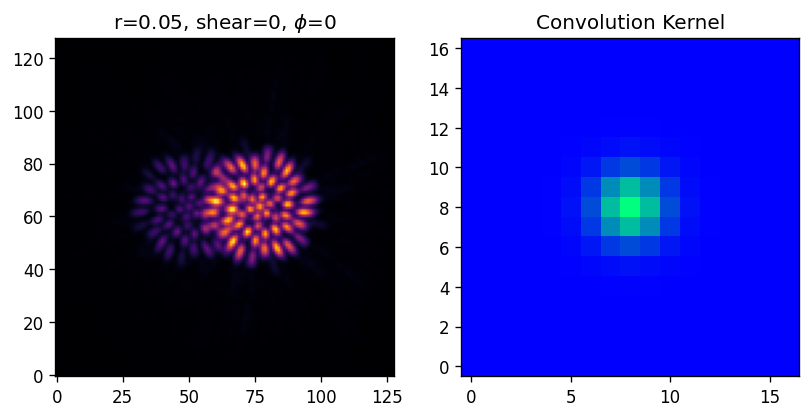

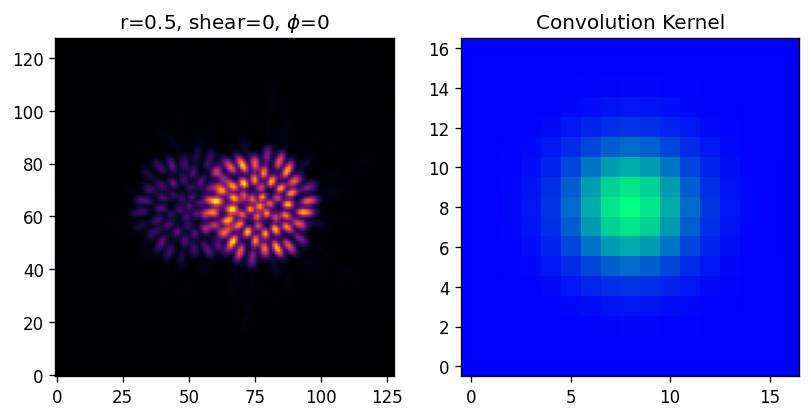

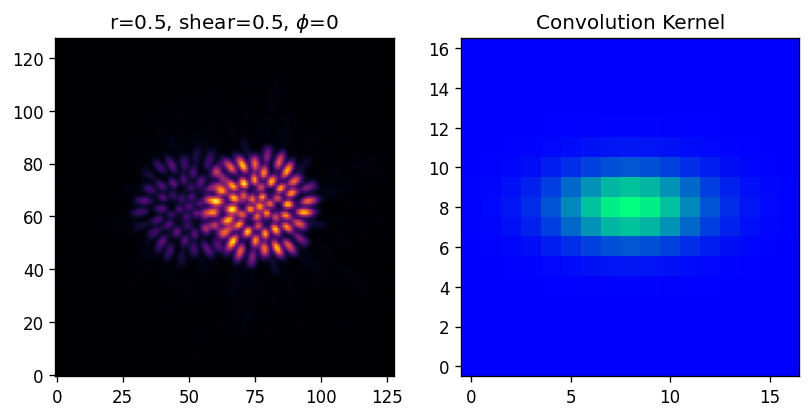

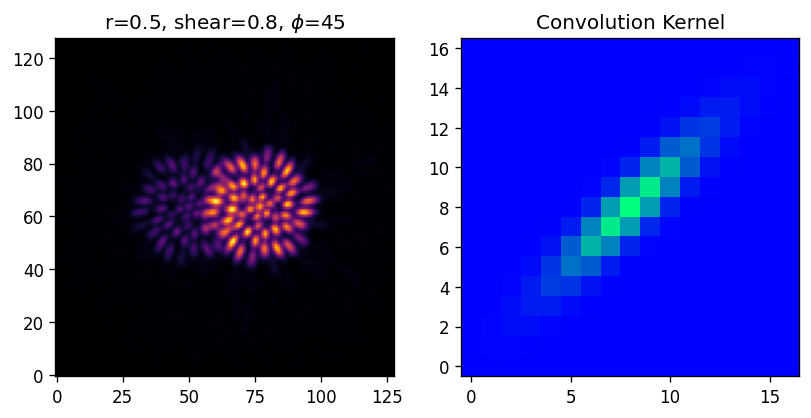

In [4]:
def show_jitter_example(instrument, r, shear, phi):
    example_model = instrument.set(['detector.Jitter.r', 'detector.Jitter.shear', 'detector.Jitter.phi'], [r, shear, phi])
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
    ax0.imshow(example_model.model())
    ax0.set(title=f'r={r}, shear={shear}, $\phi$={phi}')
    ax1.imshow(example_model.detector.Jitter.generate_kernel(pscale), cmap='winter')
    ax1.set(title='Convolution Kernel')
    plt.show()

show_jitter_example(telescope, 1e-5, 0, 0)
show_jitter_example(telescope, 0.05, 0, 0)
show_jitter_example(telescope, 0.5, 0, 0)
show_jitter_example(telescope, 0.5, 0.5, 0)
show_jitter_example(telescope, 0.5, 0.8, 45)

# Investigating Kernel Oversample
The convolution kernel is a multivariate normal generated on a coordinate grid (using `jax.scipy.stats.multivariate_normal`), however if the coordinate grid is not well-sampled, this can lead to some dodgy-looking kernels. To get around this, the kernels are generated on an oversampled grid (determined by the `Jitter.kernel_oversample` parameter), and the kernel is then downsampled before convolution. Here we investigate the residuals between an "ideal" PSF (with an arbitrarily large `kernel_oversample`) and the PSF of varying `kernel_oversample` values, to determine the ideal `kernel_oversample` to use later such that it comprimises between error and compute time.

We will do a similar investigation for `kernel_size`.

In [5]:
mags = np.array([0.001, 0.005, 0.02])  # magnitude (r) values to investigate
ko_resss = []
kos = np.array([1, 2, 4, 9, 16, 25, 36])

for mag in mags:
    tel = telescope.set(["Jitter.r", "Jitter.kernel_oversample"], [mag, 100])
    ideal = tel.model()
    ress = []

    for ko in kos:
        tel = tel.set("Jitter.kernel_oversample", ko)
        res = np.abs(tel.model() - ideal).sum() 
        ress.append(res)

    ress = 100 * np.array(ress) / ideal.sum()
    ko_resss.append(ress)

In [6]:
ks_resss = []
kss = np.array([5, 10, 13, 17, 21, 27])

for mag in mags:
    tel = telescope.set(["Jitter.r", "Jitter.kernel_size"], [mag, 31])
    ideal = tel.model()
    ress = []

    for ks in kss:
        tel = tel.set("Jitter.kernel_size", ks)
        res = np.abs(tel.model() - ideal).sum() 
        ress.append(res)

    ress = 100 * np.array(ress) / ideal.sum()
    ks_resss.append(ress)

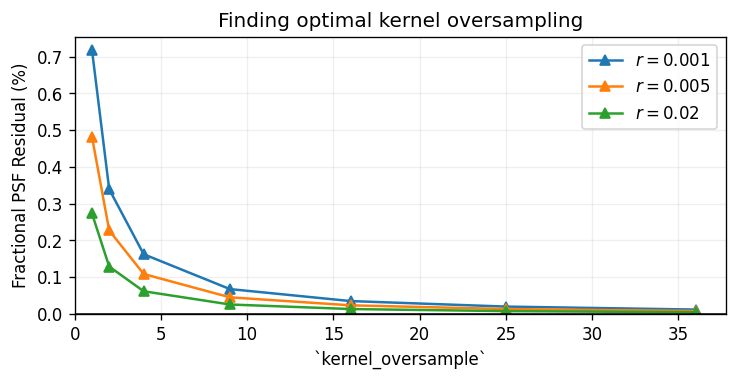

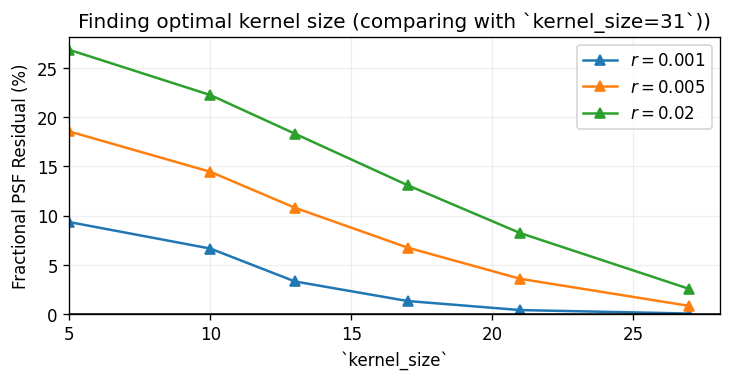

In [7]:
# kernel oversample
fig, ax = plt.subplots(figsize=(7,3))
for mag, ress in zip(mags, ko_resss):
    ax.plot(kos, ress, marker='^', label=f'$r={mag}$')
ax.axhline(0, color='k')
ax.set(
    xlabel='`kernel_oversample`',
    ylabel='Fractional PSF Residual (%)',
    xlim=(0, None),
    ylim=(0, None),
    title='Finding optimal kernel oversampling'
)
ax.grid(alpha=0.2)
ax.legend()
plt.show()

# kernel size
fig, ax = plt.subplots(figsize=(7,3))
for mag, ress in zip(mags, ks_resss):
    ax.plot(kss, ress, marker='^', label=f'$r={mag}$')
ax.axhline(0, color='k')
ax.set(
    xlabel='`kernel_size`',
    ylabel='Fractional PSF Residual (%)',
    xlim=(5, None),
    ylim=(0, None),
    title='Finding optimal kernel size (comparing with `kernel_size=31`))'
)
ax.grid(alpha=0.2)
ax.legend()
plt.show()

## Fisher Analysis
Now we will perform a Fisher analysis to determine the effect of jitter on the ability to constrain these parameters. We will do this by calculating the covariance matrix of the parameters of interest. We will then plot the standard deviation of each parameter as a function of the jitter magnitude.

In [8]:
# Marginal params
params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'wavelengths',
    'psf_pixel_scale',
    'Jitter.r',
    'Jitter.shear',
    'Jitter.phi',
    'aperture.coefficients',
]

# We can use the shape_dict to force the shape of the perturbing parameter to be a scalar,
# resulting in the model constraining the mean value of the wavelengths array.
shape_dict = {'wavelengths': 1}

# Define our likelihood function and bind it to our covariance function
# We use poissonian here because we are assuming photon noise is our dominant noise source
calc_cov = lambda model, parameters: zdx.self_covariance_matrix(model, parameters, zdx.poiss_loglike, shape_dict=shape_dict)
cov_fn = zdx.filter_jit(calc_cov)

# Compile
cov_fn(telescope, params);

# Bar sizes
rs = np.array([1e-4, 5e-3, 1e-2, 0.03, 0.05, 0.1, 0.2]) /4
phis = np.array([0, 30, 60, 90])
# rs = np.array([1e-4, 0.03, 0.2]) /4
# phis = np.array([0])
shears = np.array([0, 0.4, 0.7, 0.9])

covs, seps, pas, xs, ys, fluxes, conts = [], [], [], [], [], [], []

# sep_array = numpy.zeros((len(shears), len(phis), len(rs)))
for r_idx, r in tqdm(enumerate(rs), total=len(rs)):
    # Set mask width
    model = telescope.set("detector.Jitter.r", r)
    
    for shear_idx, shear in enumerate(shears):
        # Set mask width
        model = model.set("detector.Jitter.shear", shear)
        
        for phi_idx, phi in enumerate(phis):
            # Set mask width
            model = model.set("detector.Jitter.phi", phi)
            
            # Calculate covariance matrix and standard deviations
            # cov = calc_cov(model, params)
            cov = cov_fn(model, params)
            covs.append(cov)
        
            stds = np.sqrt(np.diag(np.abs(cov)))
        
            # Save values
            seps.append(stds[0])
            # pas.append(stds[1])
            # xs.append(stds[2])
            # ys.append(stds[3])
            # fluxes.append(stds[4])
            # conts.append(stds[5])
        
seps = np.array(seps).reshape(len(rs), len(shears), len(phis))
# pas = np.array(pas).reshape(len(rs), len(shears), len(phis))
# xs = np.array(xs).reshape(len(rs), len(shears), len(phis))
# ys = np.array(ys).reshape(len(rs), len(shears), len(phis))
# fluxes = np.array(fluxes).reshape(len(rs), len(shears), len(phis))
# conts = np.array(conts).reshape(len(rs), len(shears), len(phis))

# covs = np.array(covs).
# ents = vmap(zdx.covaraince_entropy)(covs)

  0%|          | 0/7 [00:00<?, ?it/s]

## Plotting
Now we will plot the standard deviation of each parameter as a function of the jitter magnitude. We will plot the standard deviation for each shear value on a separate axis.

In [45]:
def plot_param_std(parameter, rs, phis, shears, param_name: str = None, unit: str = None, save=False, louis=False):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    
    for shear_idx, row, col in zip(range(4), [0, 0, 1, 1], [0, 1, 0, 1]):
    
        ax[row][col].plot(rs, parameter[:, shear_idx, :], label=phis, marker='^', markersize=5,  clip_on=False)
        # ax[row][col].axhline(0., linestyle='-', color='k')
        ax[row][col].set(
            title=param_name + f': Shear = {shears[shear_idx]}',
            xlabel='det$\Sigma$ ($\sigma_x^2 \sigma_y^2$)',
            ylabel=f'$\sigma$ of {param_name} [{unit}]',
            xlim=(0, rs.max()),
            # ylim=(0, None)
        )
        ax[row][col].axhline(2.6337281, linestyle='-.', c='k', label='LD Est.')
        ax[row][col].grid(True, alpha=0.5, linestyle='--')
        ax[row][col].legend()
    if save:
        plt.savefig('figs/jitter_analysis.pdf', bbox_inches='tight')
    plt.show()

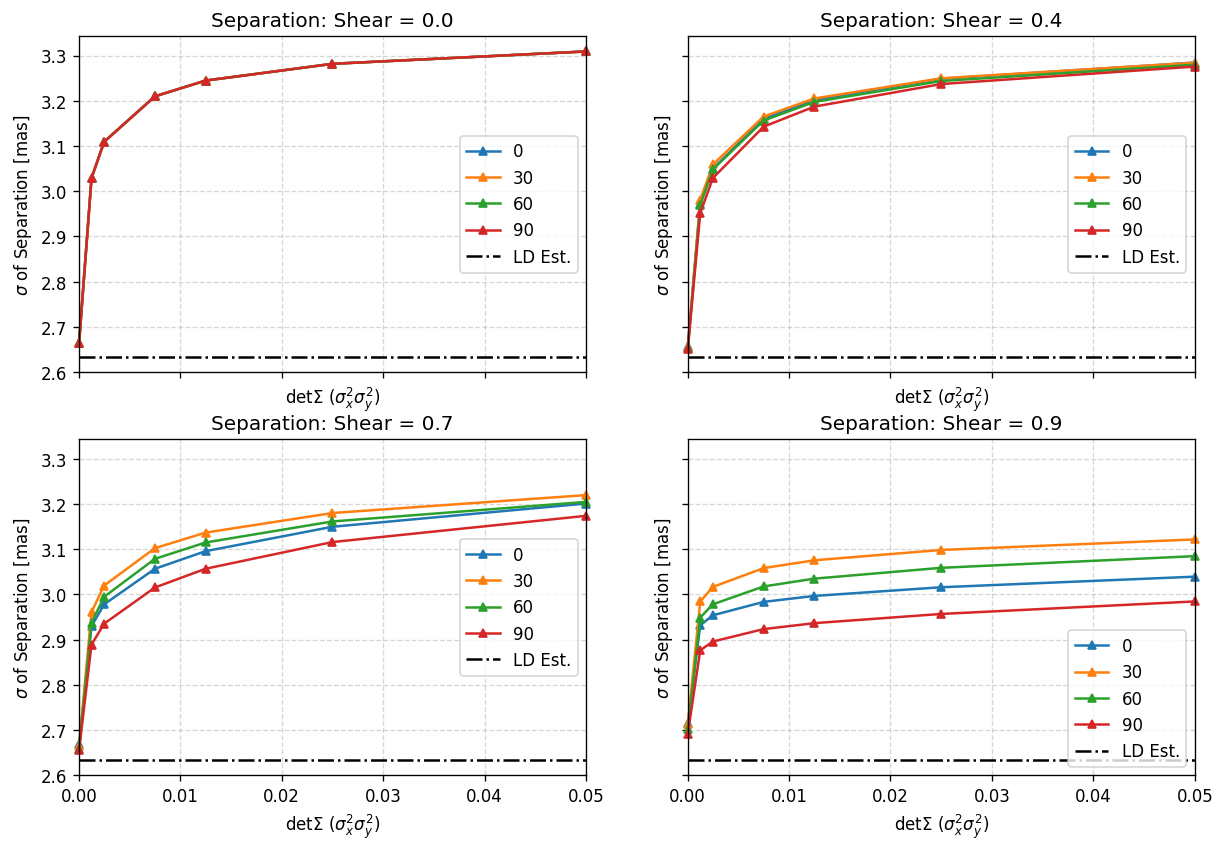

In [46]:
plot_param_std(1000*seps, rs, phis, shears, param_name='Separation', unit='mas', save=False, louis=True)
# print("Okay let's look at how the other parameters were constrained just for funsies.")
# plot_param_std(pas, rs, phis, shears, param_name='Position Angle', unit='deg')
# plot_param_std(xs, rs, phis, shears, param_name='X Position', unit='arcsec')
# plot_param_std(ys, rs, phis, shears, param_name='Y Position', unit='arcsec')
# plot_param_std(fluxes, rs, phis, shears, param_name='Flux', unit='photons')
# plot_param_std(conts, rs, phis, shears, param_name='Contrast', unit='n/a')